In [1]:
import pandas as pd
from cryptocmd import CmcScraper
import tensorflow as tf
from tensorflow.keras import layers
from datetime import datetime
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.optimizers import Adam
from matplotlib import style, pyplot as plt
from sklearn.metrics import confusion_matrix
import seaborn as sns


tf.random.set_seed(42)
WINDOW = 7
HALVING_DATES = [datetime.strptime(date, "%d/%m/%Y") for date in ['09/07/2016', '11/05/2020', '02/03/2024']]

In [2]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
physical_devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [3]:
%matplotlib inline
style.use('ggplot')

In [4]:
def get_crypto_df(sym):
    scraper = CmcScraper(sym)
    return scraper.get_dataframe()

In [5]:
def days_till_halving(row, halving_dates=HALVING_DATES):
    date = row.Date
    closest_halving_index = 0
    while halving_dates[closest_halving_index] < date:
        closest_halving_index += 1
    delta = halving_dates[closest_halving_index] - date
    return delta.days

In [6]:
def block_size(row, halving_dates=HALVING_DATES):
    date = row.Date
    i = 0
    size = 25
    while date > halving_dates[i]:
        i += 1
        size /= 2
    return size

In [7]:
def get_label_values_from_dataframe(df, window_size=WINDOW):
    res = df.copy()
    y = df.iloc[window_size:]["Increment"].to_numpy()
    x = np.array([res.iloc[i: window_size + i].to_numpy() for i in range(len(res) - window_size)])
    return x, y

In [8]:
def shuffle_together(a, b):
    assert len(a) == len(b)
    shuffled_a = np.empty(a.shape, dtype=a.dtype)
    shuffled_b = np.empty(b.shape, dtype=b.dtype)
    permutation = np.random.permutation(len(a))
    for old_index, new_index in enumerate(permutation):
        shuffled_a[new_index] = a[old_index]
        shuffled_b[new_index] = b[old_index]
    return shuffled_a, shuffled_b

In [9]:
def create_Xt_Yt(X, y, split_size=0.9):
    split = int(len(X) * split_size)
    X_train = X[0:split]
    Y_train = y[0:split]
    X_train, Y_train = shuffle_together(X_train, Y_train)
    X_test = X[split:]
    Y_test = y[split:]
    return X_train, X_test, Y_train, Y_test

In [10]:
def find_gap(df):
    gap_res = []
    gap_res.append(0)
    for i in range(0,len(df)-1):
        gap = abs(df["Open"][i+1] - df["Close"][i]) / df["Close"][i]
        gap_res.append(gap)
    return pd.DataFrame(gap_res)

In [11]:
def find_emad(df, fast, slow):
    params = [fast,slow]
    params = pd.DataFrame(params)
    faster = int(params.min())
    slower = int(params.max())
    alpha_slow = 2 / (slower + 1)
    sma_slow = []
    ema_slow = []
    for i in range(0,len(df)):
        smas = 0 if (i < (slower-1)) else df["Close"][i-(slower-1):i+1].mean()
        sma_slow.append(smas)
        if i < (slower-1):
            emas = 0
        elif i == (slower-1):
            emas = df["Close"][i-(slower-1):i+1].mean()
        else:
            emas = (alpha_slow * df["Close"][i]) + ((1 - alpha_slow)*ema_slow[i-1])
        ema_slow.append(emas)
    alpha_fast = 2 / (faster + 1)
    sma_fast = []
    ema_fast = []
    for i in range(0,len(df)):
        smaf = 0 if (i < (slower-1)) else df["Close"][i-(faster-1):i+1].mean()
        sma_fast.append(smaf)
        if i < (slower-1):
            emaf = 0
        elif i == (slower-1):
            emaf = df["Close"][i-(faster-1):i+1].mean()
        else:
            emaf = (alpha_fast * df["Close"][i]) + ((1 - alpha_fast)*ema_fast[i-1])
        ema_fast.append(emaf)
    emad_res = pd.DataFrame(ema_fast) - pd.DataFrame(ema_slow)
    return emad_res

In [12]:
def find_stoch(df, k, smooth):
    params = [k,smooth]
    params = pd.DataFrame(params)
    smooth_per = int(params.min())
    k_per = int(params.max())
    otstup = (k_per + smooth_per)-1
    max_high = []
    min_low = []
    k_res = []
    for i in range(0,len(df)):
        high = 0 if (i < (k_per-1)) else df["High"][i-(k_per-1):i+1].max()
        low = 0 if (i < (k_per-1)) else df["Low"][i-(k_per-1):i+1].min()
        k_pokaz = 0 if (i < (k_per-1)) else (df["Close"][i] - low) / (high - low)
        max_high.append(high)
        min_low.append(low)
        k_res.append(k_pokaz)
    stoch_k = pd.DataFrame(k_res)
    stoch_res = []
    for i in range(0,len(df)):
        smooth_k = 0 if (i < (otstup-1)) else stoch_k[i-(smooth_per-1):i+1].mean()
        stoch_res.append(float(smooth_k))
    return pd.DataFrame(stoch_res)

In [13]:
def find_volat(df, period):
    volat_res = []
    for i in range(0,len(df)):
        volat = 0 if (i < (period-1)) else df["Close"][i-(period-1):i+1].std()
        volat_res.append(volat)
    return pd.DataFrame(volat_res)

In [14]:
def plot_confusion_matrix(y_test, y_preds, title):
    sns.set(font_scale=2)
    fig, ax = plt.subplots(figsize=(12, 8))
    ax = sns.heatmap(confusion_matrix(y_test, y_preds),                     
                     annot=True,                
                     cmap="Oranges",linewidths=.10, fmt= '.0f',
                     annot_kws={
                    'fontsize': 30,
                    })
    plt.title(title, fontsize=30)
    plt.xlabel("Valor real", fontsize=25)
    plt.ylabel("Valor predicho", fontsize=25)

In [15]:
df_original = get_crypto_df('BTC')[::-1]
df_original

,Date,Open,High,Low,Close,Volume,Market Cap
3405,2013-04-28,135.300003,135.979996,132.100006,134.210007,0.000000e+00,1.488567e+09
3404,2013-04-29,134.444000,147.488007,134.000000,144.539993,0.000000e+00,1.603769e+09
3403,2013-04-30,144.000000,146.929993,134.050003,139.000000,0.000000e+00,1.542813e+09
3402,2013-05-01,139.000000,139.889999,107.720001,116.989998,0.000000e+00,1.298955e+09
3401,2013-05-02,116.379997,125.599998,92.281898,105.209999,0.000000e+00,1.168517e+09
...,...,...,...,...,...,...,...
4,2022-08-20,20872.842174,21350.806299,20856.731336,21166.060396,2.759567e+10,4.048481e+11
3,2022-08-21,21160.392783,21668.845908,21103.196808,21534.121231,2.310231e+10,4.119067e+11
2,2022-08-22,21531.463849,21531.463849,20939.184173,21398.908350,3.166650e+10,4.093401e+11
1,2022-08-23,21401.045670,21646.203762,20955.138156,21528.087372,3.187828e+10,4.118332e+11


In [16]:
fast_emad = 8
slow_emad = 18
k_stoch = 5
smooth_stoch = 3
period_volat = 6
window_autocorr = 30
lag_autocorr = 4
log_ret = pd.Series(np.log(df_original['Close']).diff())
df_original['Autocorrelacion'] = log_ret.rolling(window=window_autocorr,
min_periods=window_autocorr, center=False).apply(lambda row: row.autocorr(lag=lag_autocorr),raw=False)

In [17]:
df_original['Gap'] = find_gap(df_original)
df_original['Vol_to_MC'] = df_original.apply(lambda row: row.Volume / row["Market Cap"], axis=1)
df_original['Increment'] = df_original.apply(lambda row: (row.Close - row.Open) / row.Open, axis=1)
df_original['Increment_is_negative'] = df_original["Increment"] < 0
df_original['Increment'] = np.abs(df_original["Increment"])
df_original['Highest_difference'] = df_original.apply(lambda row: (row.High - row.Low) / row.Low, axis=1)
df_original['EMAD'] = find_emad(df_original, fast_emad, slow_emad)
df_original['Stoch'] = find_stoch(df_original, k_stoch, smooth_stoch)
df_original['Volatility'] = find_volat(df_original, period_volat)
df_original['DTH'] = df_original.apply(days_till_halving, axis=1)
df_original['BS'] = df_original.apply(block_size, axis=1)
df_original = df_original.set_index('Date').astype('float32')

In [18]:
df_original

,Open,High,Low,Close,Volume,Market Cap,Autocorrelacion,Gap,Vol_to_MC,Increment,Increment_is_negative,Highest_difference,EMAD,Stoch,Volatility,DTH,BS
Date,,,,,,,,,,,,,,,,,
2013-04-28,135.300003,135.979996,132.100006,134.210007,0.000000e+00,1.488567e+09,NaN,0.063927,0.000000,0.008056,1.0,0.029372,4.778623,-12.937468,253.136566,1168.0,25.00
2013-04-29,134.444000,147.488007,134.000000,144.539993,0.000000e+00,1.603769e+09,NaN,0.032777,0.000000,0.075094,0.0,0.100657,3.914974,-7.427945,819.610779,1167.0,25.00
2013-04-30,144.000000,146.929993,134.050003,139.000000,0.000000e+00,1.542813e+09,NaN,0.230874,0.000000,0.034722,1.0,0.096083,0.806205,-6.446571,1072.546387,1166.0,25.00
2013-05-01,139.000000,139.889999,107.720001,116.989998,0.000000e+00,1.298955e+09,NaN,0.321167,0.000000,0.158345,1.0,0.298645,-2.757026,-5.518248,1288.534302,1165.0,25.00
2013-05-02,116.379997,125.599998,92.281898,105.209999,0.000000e+00,1.168518e+09,NaN,0.190588,0.000000,0.095979,1.0,0.361047,-4.085466,-7.497701,1398.453979,1164.0,25.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-20,20872.841797,21350.806641,20856.730469,21166.060547,2.759567e+10,4.048481e+11,-0.093350,0.030708,0.068163,0.014048,0.0,0.023689,0.000000,0.000000,0.000000,560.0,6.25
2022-08-21,21160.392578,21668.845703,21103.197266,21534.121094,2.310231e+10,4.119067e+11,-0.119438,0.011146,0.056086,0.017662,0.0,0.026804,0.000000,0.000000,0.000000,559.0,6.25
2022-08-22,21531.462891,21531.462891,20939.183594,21398.908203,3.166650e+10,4.093401e+11,-0.080892,0.000157,0.077360,0.006156,1.0,0.028286,0.000000,0.000000,0.000000,558.0,6.25


In [19]:
lishnee = [fast_emad, slow_emad, k_stoch, smooth_stoch, period_volat, k_stoch+smooth_stoch-1,
window_autocorr+1, lag_autocorr]
row_del = int(max(lishnee))
row_del

31

In [20]:
df_original = df_original[row_del-1:]
df_original = df_original.fillna(0)

In [21]:
df_original

,Open,High,Low,Close,Volume,Market Cap,Autocorrelacion,Gap,Vol_to_MC,Increment,Increment_is_negative,Highest_difference,EMAD,Stoch,Volatility,DTH,BS
Date,,,,,,,,,,,,,,,,,
2013-05-28,129.770004,130.580002,125.599998,129.000000,0.000000e+00,1.446190e+09,-0.244994,0.019123,0.000000,0.005934,1.0,0.039650,6.993731,-9.245036,675.606506,1138.0,25.00
2013-05-29,129.000000,132.589996,127.662003,132.300003,0.000000e+00,1.483735e+09,-0.157953,0.001561,0.000000,0.025581,0.0,0.038602,7.349885,-8.197496,380.031067,1137.0,25.00
2013-05-30,132.250000,132.250000,127.000000,128.798996,0.000000e+00,1.445054e+09,-0.105131,0.025194,0.000000,0.026095,1.0,0.041339,7.059991,-6.887929,403.451416,1136.0,25.00
2013-05-31,128.798996,129.899994,126.400002,129.000000,0.000000e+00,1.447870e+09,0.022435,0.003875,0.000000,0.001561,0.0,0.027690,6.994516,-5.877882,967.221436,1135.0,25.00
2013-06-01,128.815002,129.779999,127.198997,129.300003,0.000000e+00,1.451916e+09,-0.143317,0.053340,0.000000,0.003765,0.0,0.020291,6.631538,-5.928695,1126.801636,1134.0,25.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-08-20,20872.841797,21350.806641,20856.730469,21166.060547,2.759567e+10,4.048481e+11,-0.093350,0.030708,0.068163,0.014048,0.0,0.023689,0.000000,0.000000,0.000000,560.0,6.25
2022-08-21,21160.392578,21668.845703,21103.197266,21534.121094,2.310231e+10,4.119067e+11,-0.119438,0.011146,0.056086,0.017662,0.0,0.026804,0.000000,0.000000,0.000000,559.0,6.25
2022-08-22,21531.462891,21531.462891,20939.183594,21398.908203,3.166650e+10,4.093401e+11,-0.080892,0.000157,0.077360,0.006156,1.0,0.028286,0.000000,0.000000,0.000000,558.0,6.25


In [22]:
min_max_scaler = MinMaxScaler()
df_original['Gap'] = min_max_scaler.fit_transform(df_original.Gap.values.reshape(-1,1))
df_original['Highest_difference'] = min_max_scaler.fit_transform(df_original.Highest_difference.values.reshape(-1,1))
df_original['Increment'] = min_max_scaler.fit_transform(df_original.Increment.values.reshape(-1,1))
df_original['Vol_to_MC'] = min_max_scaler.fit_transform(df_original.Vol_to_MC.values.reshape(-1,1))
df_original['EMAD'] = min_max_scaler.fit_transform(df_original.EMAD.values.reshape(-1,1))
df_original['Stoch'] = min_max_scaler.fit_transform(df_original.Stoch.values.reshape(-1,1))
df_original['Volatility'] = min_max_scaler.fit_transform(df_original.Volatility.values.reshape(-1,1))
df_original['Autocorrelacion'] = min_max_scaler.fit_transform(df_original.Autocorrelacion.values.reshape(-1,1))
df_original['DTH'] = min_max_scaler.fit_transform(df_original.DTH.values.reshape(-1,1))
df_original['BS'] = min_max_scaler.fit_transform(df_original.BS.values.reshape(-1,1))
df_original['Increment'] = df_original.apply(lambda row: -row.Increment if row.Increment_is_negative else row.Increment, axis=1)

In [23]:
delete_cols = ["Open", "Close", "High", "Low", "Market Cap", "Volume", "Increment_is_negative"]
for col in delete_cols:
    del df_original[col]

In [24]:
df_original

,Autocorrelacion,Gap,Vol_to_MC,Increment,Highest_difference,EMAD,Stoch,Volatility,DTH,BS
Date,,,,,,,,,,
2013-05-28,0.357091,0.032340,0.000000,-0.014236,0.051743,0.405195,0.009268,0.152979,0.812277,1.0
2013-05-29,0.418653,0.002639,0.000000,0.061374,0.050376,0.405226,0.009441,0.086051,0.811563,1.0
2013-05-30,0.456013,0.042606,0.000000,-0.062605,0.053947,0.405201,0.009657,0.091354,0.810849,1.0
2013-05-31,0.546237,0.006553,0.000000,0.003744,0.036136,0.405195,0.009824,0.219010,0.810136,1.0
2013-06-01,0.429005,0.090205,0.000000,0.009033,0.026480,0.405162,0.009816,0.255144,0.809422,1.0
...,...,...,...,...,...,...,...,...,...,...
2022-08-20,0.464346,0.051932,0.093429,0.033703,0.030915,0.404573,0.010795,0.000000,0.399714,0.0
2022-08-21,0.445894,0.018850,0.076876,0.042373,0.034980,0.404573,0.010795,0.000000,0.399001,0.0
2022-08-22,0.473157,0.000265,0.106035,-0.014770,0.036913,0.404573,0.010795,0.000000,0.398287,0.0


In [25]:
X, Y = get_label_values_from_dataframe(df_original)
n_values = df_original.shape[1]

In [26]:
X_train, X_test, Y_train, Y_test = create_Xt_Yt(X, Y)
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], n_values))
X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], n_values))

In [27]:
model= tf.keras.Sequential([
    layers.Conv1D(input_shape = (WINDOW, n_values),filters=16,kernel_size=4,padding='same'),
    layers.MaxPooling1D(pool_size=3),
    layers.LeakyReLU(),
    layers.Conv1D(filters=32,kernel_size=4,padding='same'),
    layers.MaxPooling1D(pool_size=2),
    layers.LeakyReLU(),
    layers.LSTM(64,return_sequences=True),
    layers.Flatten(),
    layers.Dense(32),
    layers.LeakyReLU(),
    layers.Dropout(0.7),
    layers.Dense(1),
    layers.Activation('linear')
], name="multivariable")    

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.9, patience=25, min_lr=0.000001,
verbose=1)
checkpointer = ModelCheckpoint(filepath=model.name, verbose=1, save_best_only=True)
model.compile(optimizer=Adam(lr=0.001), loss='mean_squared_error')

In [28]:
history = model.fit(X_train, Y_train,
    epochs = 200,
    batch_size = 128,
    verbose=1,
    validation_data=(X_test, Y_test),
    callbacks=[reduce_lr, checkpointer],
    shuffle=True)

Epoch 1/200
24/24 [==============================] - ETA: 0s - loss: 0.0107
Epoch 00001: val_loss improved from inf to 0.00717, saving model to multivariable
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: multivariable/assets
24/24 [==============================] - 3s 134ms/step - loss: 0.0107 - val_loss: 0.0072 - lr: 0.0010
Epoch 2/200
16/24 [===================>..........] - ETA: 0s - loss: 0.0099
Epoch 00002: val_loss did not improve from 0.00717
24/24 [==============================] - 0s 4ms/step - loss: 0.0105 - val_loss: 0.0072 - lr: 0.0010
Epoch 3/200
20/24 [========================>.....] - ETA: 0s - loss: 0.0103
Epoch 00003: val_loss improved from 0.00717 to 0.00708, saving model to multivariable
INFO:tensorflow:Assets written to: multivariable/assets
24/24 [==============================] - 3s 124ms/step - loss: 0.0103 - val_loss: 0.0071 - lr: 0.0010
Epoch 4/200
17/24 [====================>.........] - ETA

Epoch 33/200
22/24 [==========================>...] - ETA: 0s - loss: 0.0074
Epoch 00033: val_loss did not improve from 0.00684
24/24 [==============================] - 0s 3ms/step - loss: 0.0073 - val_loss: 0.0096 - lr: 9.0000e-04
Epoch 34/200
23/24 [===========================>..] - ETA: 0s - loss: 0.0071
Epoch 00034: val_loss did not improve from 0.00684
24/24 [==============================] - 0s 3ms/step - loss: 0.0071 - val_loss: 0.0083 - lr: 9.0000e-04
Epoch 35/200
23/24 [===========================>..] - ETA: 0s - loss: 0.0069
Epoch 00035: val_loss did not improve from 0.00684
24/24 [==============================] - 0s 3ms/step - loss: 0.0071 - val_loss: 0.0091 - lr: 9.0000e-04
Epoch 36/200
22/24 [==========================>...] - ETA: 0s - loss: 0.0074
Epoch 00036: val_loss did not improve from 0.00684
24/24 [==============================] - 0s 3ms/step - loss: 0.0073 - val_loss: 0.0089 - lr: 9.0000e-04
Epoch 37/200
24/24 [==============================] - ETA: 0s - loss: 0.

Epoch 68/200
24/24 [==============================] - ETA: 0s - loss: 0.0050
Epoch 00068: val_loss did not improve from 0.00684
24/24 [==============================] - 0s 3ms/step - loss: 0.0050 - val_loss: 0.0082 - lr: 8.1000e-04
Epoch 69/200
 1/24 [>.............................] - ETA: 0s - loss: 0.0040
Epoch 00069: val_loss did not improve from 0.00684
24/24 [==============================] - 0s 3ms/step - loss: 0.0048 - val_loss: 0.0078 - lr: 8.1000e-04
Epoch 70/200
23/24 [===========================>..] - ETA: 0s - loss: 0.0046
Epoch 00070: val_loss did not improve from 0.00684
24/24 [==============================] - 0s 3ms/step - loss: 0.0046 - val_loss: 0.0079 - lr: 8.1000e-04
Epoch 71/200
24/24 [==============================] - ETA: 0s - loss: 0.0045
Epoch 00071: val_loss did not improve from 0.00684
24/24 [==============================] - 0s 3ms/step - loss: 0.0045 - val_loss: 0.0086 - lr: 8.1000e-04
Epoch 72/200
24/24 [==============================] - ETA: 0s - loss: 0.

Epoch 103/200
21/24 [=========================>....] - ETA: 0s - loss: 0.0039
Epoch 00103: val_loss did not improve from 0.00684
24/24 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0077 - lr: 7.2900e-04
Epoch 104/200
21/24 [=========================>....] - ETA: 0s - loss: 0.0038
Epoch 00104: val_loss did not improve from 0.00684
24/24 [==============================] - 0s 3ms/step - loss: 0.0039 - val_loss: 0.0076 - lr: 7.2900e-04
Epoch 105/200
23/24 [===========================>..] - ETA: 0s - loss: 0.0038
Epoch 00105: val_loss did not improve from 0.00684
24/24 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0081 - lr: 7.2900e-04
Epoch 106/200
23/24 [===========================>..] - ETA: 0s - loss: 0.0037
Epoch 00106: ReduceLROnPlateau reducing learning rate to 0.0006561000715009868.

Epoch 00106: val_loss did not improve from 0.00684
24/24 [==============================] - 0s 3ms/step - loss: 0.0037 - val_loss: 0.0073 - lr

Epoch 138/200
24/24 [==============================] - ETA: 0s - loss: 0.0034
Epoch 00138: val_loss did not improve from 0.00674
24/24 [==============================] - 0s 3ms/step - loss: 0.0034 - val_loss: 0.0078 - lr: 6.5610e-04
Epoch 139/200
21/24 [=========================>....] - ETA: 0s - loss: 0.0032
Epoch 00139: ReduceLROnPlateau reducing learning rate to 0.0005904900433961303.

Epoch 00139: val_loss did not improve from 0.00674
24/24 [==============================] - 0s 4ms/step - loss: 0.0032 - val_loss: 0.0078 - lr: 6.5610e-04
Epoch 140/200
24/24 [==============================] - ETA: 0s - loss: 0.0032
Epoch 00140: val_loss did not improve from 0.00674
24/24 [==============================] - 0s 3ms/step - loss: 0.0032 - val_loss: 0.0079 - lr: 5.9049e-04
Epoch 141/200
21/24 [=========================>....] - ETA: 0s - loss: 0.0033
Epoch 00141: val_loss did not improve from 0.00674
24/24 [==============================] - 0s 3ms/step - loss: 0.0033 - val_loss: 0.0071 - lr

23/24 [===========================>..] - ETA: 0s - loss: 0.0030
Epoch 00172: val_loss did not improve from 0.00638
24/24 [==============================] - 0s 3ms/step - loss: 0.0030 - val_loss: 0.0071 - lr: 5.9049e-04
Epoch 173/200
19/24 [======================>.......] - ETA: 0s - loss: 0.0031
Epoch 00173: val_loss did not improve from 0.00638
24/24 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0069 - lr: 5.9049e-04
Epoch 174/200
22/24 [==========================>...] - ETA: 0s - loss: 0.0031
Epoch 00174: val_loss did not improve from 0.00638
24/24 [==============================] - 0s 3ms/step - loss: 0.0031 - val_loss: 0.0069 - lr: 5.9049e-04
Epoch 175/200
20/24 [========================>.....] - ETA: 0s - loss: 0.0032
Epoch 00175: val_loss did not improve from 0.00638
24/24 [==============================] - 0s 4ms/step - loss: 0.0031 - val_loss: 0.0068 - lr: 5.9049e-04
Epoch 176/200
21/24 [=========================>....] - ETA: 0s - loss: 0.0033
Epoc

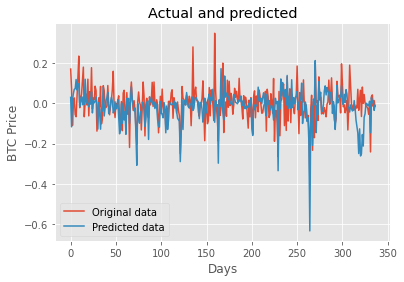

In [29]:
pred = model.predict(X_test)
original = Y_test
plt.title('Actual and predicted')
plt.plot(original, label = 'Original data')
plt.plot(pred, label = 'Predicted data')
plt.xlabel('Days')
plt.ylabel('BTC Price')
plt.legend()
plt.show()

In [30]:
matrix = confusion_matrix(Y_test > 0, pred > 0)
matrix

array([[118,  56],
       [ 60, 103]])

In [31]:
print(f"Porcentaje de bajadas acertadas: {matrix[0, 0] / np.sum(matrix[:, 0]) * 100:0.2f}%")
print(f"Porcentaje de subidas acertadas: {matrix[1, 1] / np.sum(matrix[:, 1]) * 100:0.2f}%")
acc = (matrix[0, 0] + matrix[1, 1]) / np.sum(matrix)

Porcentaje de bajadas acertadas: 66.29%
Porcentaje de subidas acertadas: 64.78%


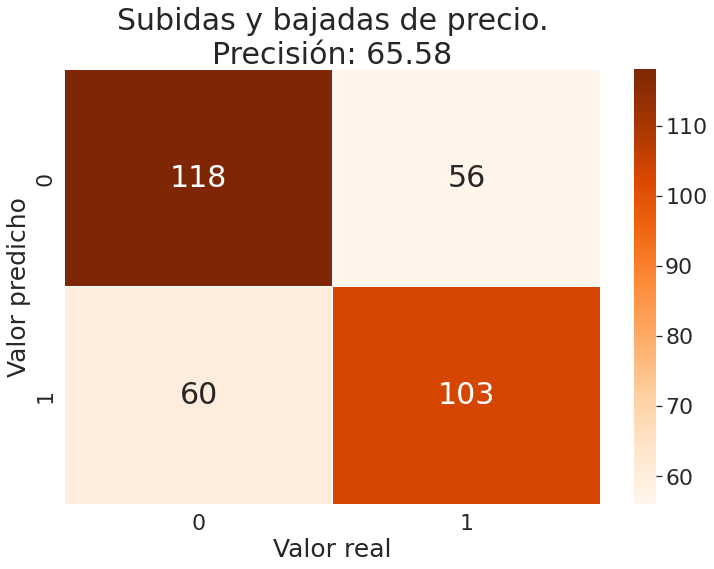

In [32]:
plot_confusion_matrix(Y_test > 0, pred > 0, 
                      f"Subidas y bajadas de precio.\nPrecisión: {acc*100:.2f}")